In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc
from prj.config import DATA_DIR, EXP_DIR
from tqdm import tqdm
from prj.agents.factory import AgentsFactory
import os

2024-12-10 13:44:58.068432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 13:44:58.068470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 13:44:58.069722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 13:44:58.076318: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 13:44:58.922727: W tensorflow/compiler/tf2

In [2]:
agent_base_dir = EXP_DIR / 'saved'
agents_dict = [
    {'agent_type': 'lgbm', 'load_path': os.path.join(agent_base_dir, "LGBMRegressor_1seeds_4_5-6_6_134802", "best_trial", "saved_model")},
    {'agent_type': 'lgbm', 'load_path': os.path.join(agent_base_dir, "LGBMRegressor_1seeds_5_6-7_7_134811", "best_trial", "saved_model")},
    {'agent_type': 'lgbm', 'load_path': os.path.join(agent_base_dir, "LGBMRegressor_1seeds_6_7-8_8_134900", "best_trial", "saved_model")},
]
agents = [AgentsFactory.load_agent(agent_dict) for agent_dict in agents_dict]

len(agents)

Loading models, overwriting seeds: [1879224255]
Loading models, overwriting seeds: [2496896330]
Loading models, overwriting seeds: [3489235709]


3

In [3]:
from prj.data.data_loader import DataLoader


# data_args = {'ffill': False, 'include_symbol_id': False}
# loader = DataLoader(**data_args)
# X, y, w, info = loader.load_partitions(start_partition=9, end_partition=9)
# np.savez(DATA_DIR / 'x_9_9.npz', X=X, y=y, w=w, info=info)

data = np.load(DATA_DIR / 'x_9_9.npz')
X = data['X']
y = data['y']
w = data['w']
info = data['info']

f = 500000
X = X[:f]
y = y[:f]
w = w[:f]
info = info[:f]

gc.collect()

X.shape, y.shape, w.shape, info.shape

((500000, 79), (500000,), (500000,), (500000, 3))

In [4]:
def squared_weighted_error_loss_fn(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w.reshape(-1, 1) * ((y_true.reshape(-1, 1) - y_pred_agents) ** 2)

def absolute_weighted_error_loss_fn(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w.reshape(-1, 1) * np.abs(y_true.reshape(-1, 1) - y_pred_agents)

def compute_loss(y_true: np.ndarray, y_pred_agents: np.ndarray, w: np.ndarray, loss_fn) -> np.ndarray:
    assert y_true.shape[0] == y_pred_agents.shape[0]
    if w is None:
        w = np.ones_like(y_true)
    assert y_true.shape[0] == w.shape[0]

    return loss_fn(y_true, y_pred_agents, w)


agents_predictions = np.concatenate([agent.predict(X).reshape(-1, 1) for agent in tqdm(agents)], axis=1)
agents_losses = compute_loss(y, agents_predictions, w, absolute_weighted_error_loss_fn)
agents_predictions.shape, agents_losses.shape, np.any(np.isnan(agents_predictions), axis=1).sum(), np.any(np.isnan(agents_losses), axis=1).sum()

100%|██████████| 3/3 [00:22<00:00,  7.39s/it]


((500000, 3), (500000, 3), 0, 0)

In [17]:

from prj.metrics import weighted_r2
from prj.oamp.oamp import OAMP
from prj.oamp.oamp_config import ConfigOAMP

oamp_args = ConfigOAMP({'agents_weights_upd_freq':10, 'loss_fn_window': 10, 'agg_type': 'mean'})
n_agents = len(agents)
oamp: OAMP = OAMP(n_agents, oamp_args)

ensemble_preds = []
for i in tqdm(range(agents_predictions.shape[0])):
    is_new_group = info[i, 1] != info[i-1, 1] if i > 0 else False
    
    ensemble_prediction = oamp.step(agents_losses[i], agents_predictions[i], is_new_group=is_new_group)
    ensemble_preds.append(ensemble_prediction)


ensemble_preds = np.array(ensemble_preds)

ensemble_preds.shape

100%|██████████| 500000/500000 [00:06<00:00, 80457.98it/s]


(500000,)

In [18]:
from prj.metrics import weighted_mae, weighted_mse, weighted_rmse

def metrics(y_true, y_pred, weights):
    return {
        'r2_w': weighted_r2(y_true, y_pred, weights=weights),
        'mae_w': weighted_mae(y_true, y_pred, weights=weights),
        'mse_w': weighted_mse(y_true, y_pred, weights=weights),
        'rmse_w': weighted_rmse(y_true, y_pred, weights=weights),
    }
    
results = {}
res = metrics(y, ensemble_preds, w)
columns = list(res.keys())
results['ensemble'] = res.values()
for i in range(n_agents):
    results[f'agent_{i}'] = metrics(y, agents_predictions[:, i], w).values()
results['mean'] = metrics(y, np.mean(agents_predictions, axis=1), w).values()
results['median'] = metrics(y, np.median(agents_predictions, axis=1), w).values()


results = pl.DataFrame(results)\
    .transpose(include_header=True, column_names=columns, header_name='Agent')\
    .sort('r2_w', descending=True) \
    .to_pandas().set_index('Agent')
results

,r2_w,mae_w,mse_w,rmse_w
Agent,,,,
ensemble,0.009741,0.510410,0.599798,0.774466
agent_2,0.008867,0.510228,0.600327,0.774808
mean,0.008758,0.510958,0.600393,0.774850
agent_1,0.008569,0.510689,0.600507,0.774924
median,0.007539,0.511061,0.601131,0.775327
agent_0,-0.002038,0.514986,0.606932,0.779058


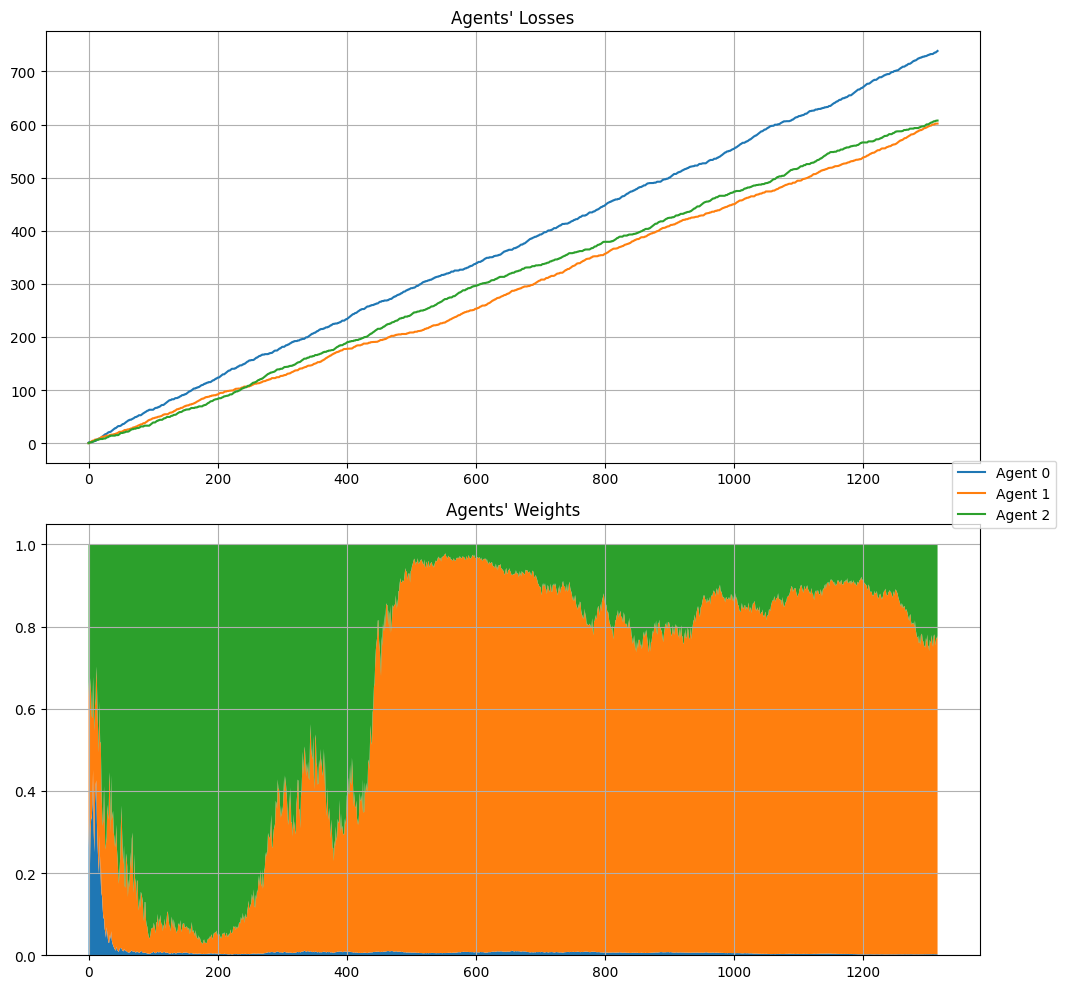

In [19]:
oamp.plot_stats()